In [ ]:
from fastai.vision.core import show_image, show_images

In [ ]:
import torch
from torch import tensor
from torch import nn

In [ ]:
from pathlib import Path
import gzip
import pickle

path_data = Path('data')
path_gz = path_data/'mnist.pkl.gzip'
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])
     

In [ ]:
top_edge = tensor([
    [ -1, -1, -1 ],
    [  0,  0,  0 ],
    [  1,  1,  1 ]
])
top_edge

tensor([[-1, -1, -1],
        [ 0,  0,  0],
        [ 1,  1,  1]])

In [ ]:
x = x_train[0]; x.shape

torch.Size([784])

<Axes: >

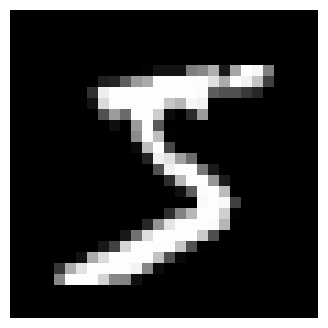

In [ ]:
show_image(x.view(28,28), figsize=(4,4), cmap='gray')

In [ ]:
top_edge.shape, x.shape

(torch.Size([3, 3]), torch.Size([784]))

top_edge, out_dim = 1, kernel = 3, stride = 1, inp_size = 28x28

$$
outsize = 28 - 3 + 1 = 26
$$

In [ ]:
x2d = x.reshape(28,28)
out = torch.zeros(26,26)

for i in range(26):
    for j in range(26):
        out[i,j] = (x2d[i:i+3, j:j+3] * top_edge).sum()

<Axes: >

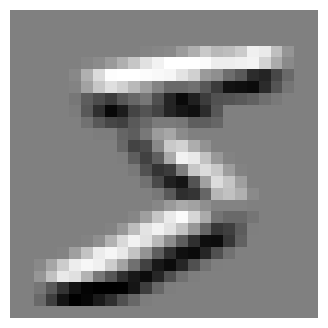

In [ ]:
show_image(out, figsize=(4,4), cmap='gray')

In [ ]:
kernels = tensor([
   [[ -1, -1, -1 ],
    [  0,  0,  0 ],
    [  1,  1,  1 ]],
   [[  1,  1,  1 ],
    [  0,  0,  0 ],
    [ -1, -1, -1 ]],
   [[ -1,  0,  1 ],
    [ -1,  0,  1 ],
    [ -1,  0,  1 ]],
   [[  1,  0, -1 ],
    [  1,  0, -1 ],
    [  1,  0, -1 ]],
]).float()


out = torch.zeros(kernels.shape[0],26,26)

for i in range(26):
    for j in range(26):
        # 3x3 * 2x3x3 => 2x3x3
        out[:,i,j] = (x2d[i:i+3, j:j+3] * kernels).sum((1,2))


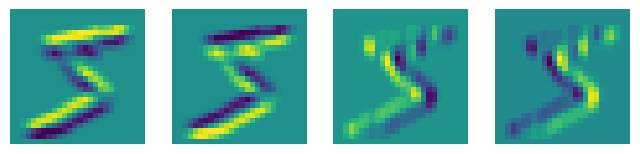

In [ ]:
# show_images([out[0],out[1],out[2]], figsize=(8,4))
show_images([out[0],out[1],out[2],out[3]], figsize=(8,4))

In [ ]:
import torch.nn.functional as F
x_unf = F.unfold(x2d[None,None,:,:].float(), (3,3)) # input B,C,H,W (Grayscale so added channel)
x_unf.shape, kernels.view(-1, 9).shape

(torch.Size([1, 9, 676]), torch.Size([4, 9]))

torch.Size([4, 9]) torch.Size([1, 9, 676])
torch.Size([1, 4, 676])


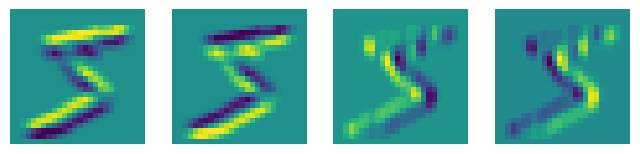

In [ ]:
# D,K @ B,K,P => B,D,P
print(kernels.view(-1,9).shape, x_unf.shape)
out = (kernels.view(-1, 9) @ x_unf)
print(out.shape)
out = out.squeeze().view(4,26,26)
show_images([out[0],out[1],out[2],out[3]], figsize=(8,4))

In [ ]:
kernels.shape, x2d.shape

(torch.Size([4, 3, 3]), torch.Size([28, 28]))

torch.Size([1, 4, 26, 26])


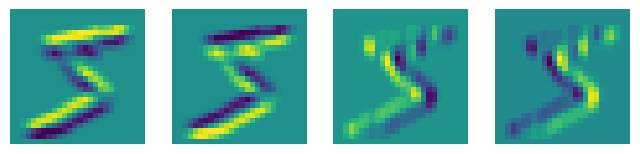

In [ ]:
out = F.conv2d(x2d[None,None,:,:].float(), kernels[:,None,:,:], )
print(out.shape)
out = out.squeeze(0)
show_images([out[0],out[1],out[2],out[3]], figsize=(8,4))

- To keep input and output same size: `kernel_size // 2`
- Stride of 2 halves output size

In [ ]:
def conv(ni, nf, ks=3, stride=2, act=True):
    res = nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

In [ ]:
simple_cnn = nn.Sequential(
    conv(1,4),                # 14x14
    conv(4,8),                # 7x7
    conv(8,16),               # 4x4
    conv(16,16),              # 2x2
    conv(16,10, act=False),   # 1x1
    nn.Flatten()
)

In [ ]:
xb = x_train[:5].view(-1, 28,28)[:,None,:]
xb.shape # B C H W

torch.Size([5, 1, 28, 28])

In [ ]:
simple_cnn(xb)

tensor([[-0.0478,  0.0830,  0.0365, -0.0461,  0.0169, -0.0197, -0.0495,  0.0595,
         -0.0365, -0.0631],
        [-0.0476,  0.0807,  0.0340, -0.0470,  0.0166, -0.0183, -0.0518,  0.0600,
         -0.0352, -0.0632],
        [-0.0483,  0.0808,  0.0346, -0.0478,  0.0160, -0.0212, -0.0522,  0.0599,
         -0.0351, -0.0639],
        [-0.0473,  0.0811,  0.0356, -0.0483,  0.0153, -0.0212, -0.0513,  0.0599,
         -0.0357, -0.0655],
        [-0.0488,  0.0823,  0.0344, -0.0461,  0.0143, -0.0193, -0.0525,  0.0619,
         -0.0351, -0.0629]], grad_fn=<ReshapeAliasBackward0>)

Reshape whole dataset:

In [ ]:
x_train = x_train.reshape(-1, 28, 28)[:, None, :, :]
x_valid = x_valid.reshape(-1, 28, 28)[:, None, :, :]

## Training

In [ ]:
from torch.utils.data import DataLoader
from torch import optim
from tinyai.datasets import BasicDataset, get_dls
from tinyai.core import to_device, def_device

In [ ]:
# gpu
# x_train, y_train, x_valid, y_valid = map(to_device, (x_train, y_train, x_valid, y_valid))
# simple_cnn = simple_cnn.to(def_device)

In [ ]:
train_ds = BasicDataset(x_train, y_train)
valid_ds = BasicDataset(x_valid, y_valid)
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs=32)
opt = optim.SGD(simple_cnn.parameters(), lr=0.4)

In [ ]:
from tinyai.training import fit

In [ ]:
fit(3, simple_cnn, F.cross_entropy, train_dl, valid_dl, opt)

Epoch 0:
Val Loss: 0.2993 Val Accuracy: 0.9137
Epoch 1:
Val Loss: 0.1634 Val Accuracy: 0.9548
Epoch 2:
Val Loss: 0.2114 Val Accuracy: 0.9351
